# P5 - Convontioneel neuraal netwerk

### libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.datasets.cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras import models, utils, Sequential
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # needed to combat a SSLCertVerificationError

### baseline model

Er zijn 10 klassen waarin voorspelt kan worden. Als je dan willekeurig gaat proberen te voorspellen heb je 10% kans dat je het goed raad, dus het baseline model is een accuracy score van 10%.

### load dataset

In [2]:
(X_train, y_train), (X_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()

### data exploration

Kijken hoe de input data eruit ziet.

In [3]:
print(X_train.shape)

(50000, 32, 32, 3)


en nu de plaatjes zelf.

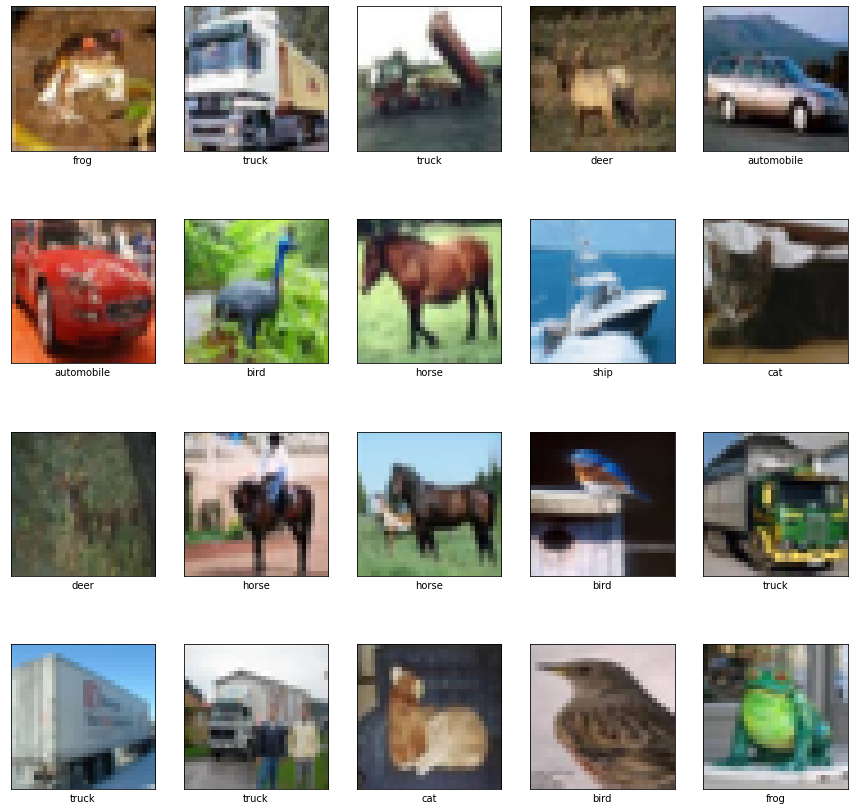

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])

plt.show()


ik heb zelf al moeite met het herkennen van sommige plaatjes, dus ben benieuwd hoe goed een netwerk ze gaat herkennen.

### data preparation

de input-data bevat nu waardes van 0 tot en met 255 om de hoeveelheid blauw, groen of rood aan te geven. Om deze goed bruikbaar te maken voor het netwerk moeten deze genormalizeert worden, zodat alle waardes tussen de 0 en 1 zitten. Dit doe je door alle waardes te delen door de hoogst mogelijke waarde wat 255 is.

de target-data moet ook aangepast worden voor het netwerk. Omdat er 10 mogelijke voorspellingen zijn moeten de targets een array zijn met een lengte van 10 met een 1 op een bepaalde index wat aangeeft wat het is. zoals bijvoorbeeld hier: 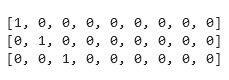

In [5]:
# normalize input data
X_train = X_train / 255
X_test = X_test / 255

In [6]:
# make the targets to arrays
n_classes = 10

Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)

### modelling

een Convnets architectuur begint met een convolutional layer, hiermee worden door filters naar patronen gezocht in een plaatje. dit geeft robuustheid wat nodig is om het juiste te herkennen, want de locatie, positie en grootte kan verschillen ondanks dat het een en hetzelfde object is.

de activatie functie die we gebruiken is RELU. dit is handig omdat de RELU makkelijk is te berekenen, wat rekenkracht bespaart. Deze layer wordt 2 keer herhaalt om het trainings proces niet te lang te maken. waarna een pooling layer volgt. het doel van de pooling layer is om het aantal neuronnen te verlagen en alleen de relevante waardes te bewaren. deze combinatie van conv relu en pool layers word ook weer 2 keren herhaalt om het trainings proces niet te lang te maken.

als laatst volgen twee fully-connected layers de eerste met RELU als activatie functie en de tweede met softmax voor de classificatie.

#### voor de parameters van de layers:

Als kernel_size heb ik gekozen voor 3 bij 3. de plaatjes zijn maar 32 bij 32 pixels, om die reden hou ik de kernel ook klein zodat de kleine patronen in de plaatjes ook herkent worden. en het blijkt te helpen vergeleken met een grotere kernel_size. padding heb ik op same gezet zodat de dimensies hetzelfde blijven. een kleinere kernel_size zorgde ook voor overfitting.


omdat de kernel_size klein is duurt het trainen ook lang, omdat het beeld in veel detail blijft. daarom heb ik niet te veel filters gedaan door er 16 te doen en 32 in de derde en vierde convolution layers. uit testen bleek het qua accuracy/tijd efficiënter te zijn om een kleine kernel_size te hebben in plaats van veel filters.


batchnormalisatie is toegevoegd omdat het het leren sneller maakt en accurater.


de fully connected layers hebben ook allebei een dropout om overfitting tegen te gaan.

#### compile parameters

ik heb adam gekozen als optimizer omdat dat het meest gebruikelijk is en het helpt met de accuracy.

In [16]:
Convnet = Sequential()

# Convolution Layer 1
Convnet.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(32,32,3), padding='same'))
Convnet.add(BatchNormalization(axis=-1))
Convnet.add(Activation('relu'))

# Convolution Layer 2
Convnet.add(Conv2D(16, (3, 3), padding='same'))
Convnet.add(BatchNormalization(axis=-1))
Convnet.add(Activation('relu'))
Convnet.add(MaxPooling2D(pool_size=(2,2)))

# Convolution Layer 3
Convnet.add(Conv2D(32,(3, 3), padding='same'))
Convnet.add(BatchNormalization(axis=-1))
Convnet.add(Activation('relu'))

# Convolution Layer 4
Convnet.add(Conv2D(32, (3, 3), padding='same'))
Convnet.add(BatchNormalization(axis=-1))
Convnet.add(Activation('relu'))
Convnet.add(MaxPooling2D(pool_size=(2,2)))
Convnet.add(Flatten())

# Fully Connected Layer 5
Convnet.add(Dense(512))
Convnet.add(Dropout(0.2))
Convnet.add(BatchNormalization(axis=-1))
Convnet.add(Activation('relu'))

# Fully Connected Layer 6                       
Convnet.add(Dropout(0.2))
Convnet.add(Dense(10))
Convnet.add(Activation('softmax'))

# compile network
Convnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### training

batch_size van 50 bleek goed te zijn. een kleinere batch size maakte het wel iets accurater maar met trainen duurde dan ook wel een stuk langer dus vond ik het niet waard.

na 10 epochs verbeterde hij met het leeren steeds 1%maar dus vond ik het niet waard om langer door te gaan.

In [17]:
training_data = Convnet.fit(X_train, Y_train, batch_size = 50, epochs=10, verbose=1, validation_split = 0.2)

Epoch 1/10
800/800 [==============================] - 110s 138ms/step - loss: 1.3290 - accuracy: 0.5278 - val_loss: 1.1340 - val_accuracy: 0.5924
Epoch 2/10
800/800 [==============================] - 110s 137ms/step - loss: 0.9329 - accuracy: 0.6711 - val_loss: 0.9201 - val_accuracy: 0.6824
Epoch 3/10
800/800 [==============================] - 101s 126ms/step - loss: 0.7792 - accuracy: 0.7232 - val_loss: 0.8586 - val_accuracy: 0.6968
Epoch 4/10
800/800 [==============================] - 98s 122ms/step - loss: 0.6611 - accuracy: 0.7671 - val_loss: 0.8695 - val_accuracy: 0.7011
Epoch 5/10
800/800 [==============================] - 99s 124ms/step - loss: 0.5730 - accuracy: 0.7977 - val_loss: 0.8715 - val_accuracy: 0.7138
Epoch 6/10
800/800 [==============================] - 97s 122ms/step - loss: 0.4932 - accuracy: 0.8253 - val_loss: 0.7633 - val_accuracy: 0.7434
Epoch 7/10
800/800 [==============================] - 100s 124ms/step - loss: 0.4161 - accuracy: 0.8540 - val_loss: 0.8701 - va

### evaluatie

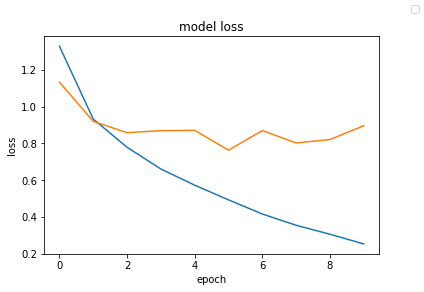

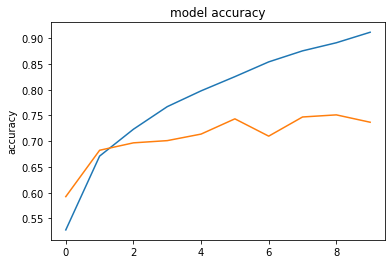

In [24]:
fig1, axs1 = plt.subplots()
fig2, axs2 = plt.subplots()

fig1.legend(['train', 'test'])

axs1.plot(training_data.history['loss'])
axs1.plot(training_data.history['val_loss'])
axs1.set_title('model loss')
axs1.set_ylabel('loss')
axs1.set_xlabel('epoch')

axs2.plot(training_data.history['accuracy'])
axs2.plot(training_data.history['val_accuracy'])
axs2.set_title('model accuracy')
axs2.set_ylabel('accuracy')
    
plt.show()

In [25]:
loss, accuracy = Convnet.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 7s 22ms/step - loss: 0.9193 - accuracy: 0.7259
Test loss: 0.9193
Test accuracy: 0.7259


het model is zeker wel overfit, maar het is niet de enige reden voor het 18% verschil in accuracy tussen de train en test data.


omdat de dataset veel variatie heeft in de soorten plaatjes vind het model het lastig om sommige plaatjes van de test set te herkennen, kijk maar bijvoorbeeld bij de data preparation waar er een blauwe vogel is met een lang nek en dan nog een merel, die twee hebben weinig met elkaar gelijk.


ik vind daarom deze score nog best goed.